# Lasso and Ridge Regularization

In [1]:
# Dependencies

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Toy Data

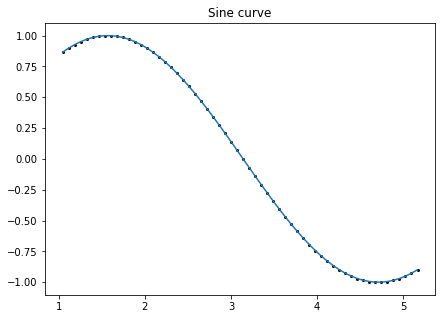

In [2]:
x = np.array([i*np.pi/180 for i in range(60,300,4)])
y = np.sin(x)
plt.scatter(x,y, color='k', s=4)
plt.plot(x,y)
plt.title("Sine curve")
plt.show()


In [3]:
def plot_model(x, y, pred):
    plt.scatter(x,y, color='k', s=4)
    plt.plot(x,pred)
    plt.title("Sine curve")
    plt.show()
    return

Adding some noise to data

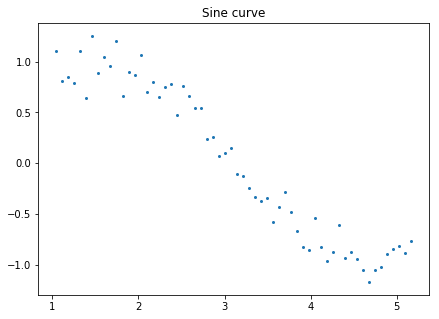

In [4]:
np.random.seed(1)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
plt.scatter(x,y, s=4)
plt.title("Sine curve")
plt.show()

Now we need to find a model that fits the data above. For that, we first select the features that comprise x and its other powers, up to power 5.

In [5]:
D = 7 # number of dimensions
X = np.ones((len(x), D+1))
for i in range(1, D+1):
    X[:,i] = x**i
    

### Ridge Regression Model

Loss is defined as the squared sum of errors for data points and the regularization loss due to weights.

L = (y - X(weights))^2/ (2*N) + reg * (weights)^2 / 2

Using Normal Equation to estimate weights.
Closed form solution is:
weights(BetaHat) = inv(X'X + reg*I) X' y

Weights:  [ 0.03685765  0.35734722  0.45727753  0.14323968 -0.4267662   0.1765359
 -0.02895372  0.00173298]
Error:  0.0189757376055


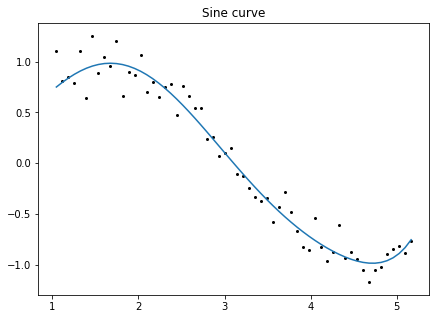

In [6]:
def estimate_model_ridge(X, y, reg, verbose=False):
    N = len(X)
    D = X.shape[1]
    I = np.ones(D)
    I[0] = 0 # Intercept term is not penalized while regularizing
    weights = np.linalg.pinv(X.T.dot(X) + reg*I).dot(X.T.dot(y))
    pred = X.dot(weights.T)
    error = pred - y
    sse = error.dot(error.T)/N
    result = {}
    result['weights'] = weights
    result['pred'] = pred
    result['sse'] = sse
    return result

# Testing linear model with ridge regression
reg = 0.5
ridgeModel = estimate_model_ridge(X, y, reg)
print ("Weights: ", ridgeModel['weights'])
print ("Error: ", ridgeModel['sse'])
plot_model(x,y,ridgeModel['pred'])

Since a closed form solution does not exist for lasso regularization case, we need to use gradient descent with lasso regularization and find out the optimal weights.

Weights:  [ 0.01568091 -0.36675138 -0.37000123 -0.27474361 -0.13187587  0.01501955
  0.16018227  0.28287843]
Error:  0.0174067234377


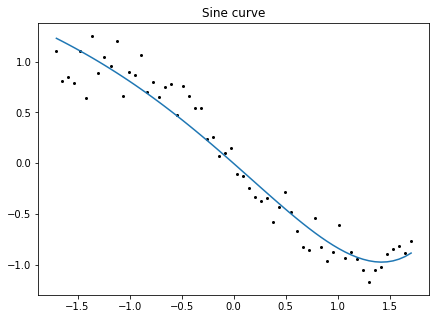

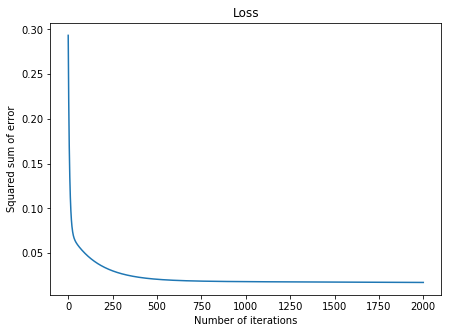

In [7]:
def normalize_features(df):
    mu = np.mean(df, axis=0)
    sd = np.std(df, axis=0)
    df = (df-mu)/sd
    return [mu, sd, df]

def estimate_model_lasso(X, y, reg, verbose=False):
    
    alpha = 1e-2
    reg = 0.001
    modelLasso = train_model_lasso(X, y, reg, alpha, verbose=False)
    record = modelLasso['record']
    bestVal = modelLasso['best_val']
    weights = bestVal['weights']
    
    result = {}
    result['weights'] = weights
    result['pred'] = X.dot(weights.T)
    result['sse'] = bestVal['sse']
    result['record'] = record
    return result

def train_model_lasso(X, y, reg, alpha, verbose=False):
    N = len(X)
    D = X.shape[1]
    np.random.seed(1)
    std = 1e-3
    weights = np.random.randn(D) * std
    if verbose:
        print ("Initial weights: ", weights)
    num_iters = 2000
    best_val = {}
    best_val['sse'] = total_error(X, y, weights, reg)
    best_val['weights'] = weights
    record = []
    record.append(total_error(X, y, weights, reg))
    for i in range(num_iters):
        weights -= alpha * gradient(X, y, weights, reg)
        sse = total_error(X, y, weights, reg)
        record.append(sse)
        if (sse < best_val['sse']):
            best_val['sse'] = sse
            best_val['weights'] = weights
        if (verbose and i%100 == 0):
            print ("Iteration %d: Loss = %f" % (i, sse))
        model = {}
        model['best_val'] = best_val
        model['record'] = record
    return model


def gradient(X, y, weights, reg):
    N = len(X)
    pred = X.dot(weights)
    diff = pred - y
    grad = diff.dot(X)/N
    # Intercept term is not regularized
    reg_grad = reg/N
    grad[1:] += reg_grad
    return grad
            
def total_error(X, y, weights, reg):
    pred = X.dot(weights)
    diff = y-pred
    sse = np.sum(diff**2)/(2*len(X)) + reg * np.sum(np.abs(weights))
    return sse

# Testing linear model with lasso regression
mu, sd, df = normalize_features(X[:, 1:])
Xnorm = X
Xnorm[:,1:] = df
lassoModel = estimate_model_lasso(Xnorm, y, reg)
print ("Weights: ", lassoModel['weights'])
print ("Error: ", lassoModel['sse'])

plot_model(Xnorm[:,1],y,lassoModel['pred'])

plt.plot(np.arange(len(lassoModel['record'])), lassoModel['record'])
plt.title("Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Squared sum of error")
plt.show()

In [8]:
def plot_model_variations(D, x, y, models, reg):
    plt.subplot(141)
    plt.scatter(x,y, color='k', s=4)
    plt.plot(x,models[0]['pred'])
    plt.title("dim = %d, reg = %f" % (D, reg[0]))
    
    plt.subplot(142)
    plt.scatter(x,y, color='k', s=4)
    plt.plot(x,models[1]['pred'])
    plt.title("dim = %d, reg = %f" % (D, reg[1]))
    
    plt.subplot(143)
    plt.scatter(x,y, color='k', s=4)
    plt.plot(x,models[2]['pred'])
    plt.title("dim = %d, reg = %f" % (D, reg[2]))
    
    plt.subplot(144)
    plt.scatter(x,y, color='k', s=4)
    plt.plot(x,models[3]['pred'])
    plt.title("dim = %d, reg = %f" % (D, reg[3]))
    
    plt.show()
    return


## Varying the hyper parameters in models

Implementing L1 regularization (Lasso) and L2 regularization (Ridge) and playing around with hyper parameters indeed build a very good understanding about how the models work and vary with changes in hyper parameters. The plots below aim to explore the same.



Data with feature dimensions of the order of 5

Ridge Regularization


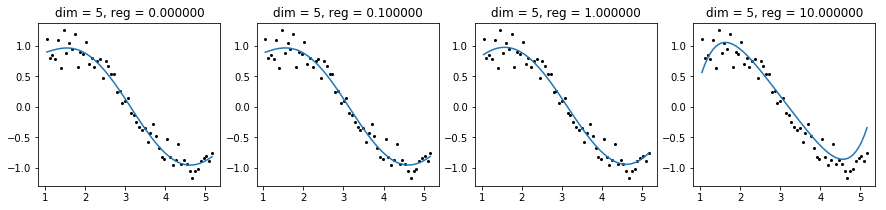


Lasso Regularization


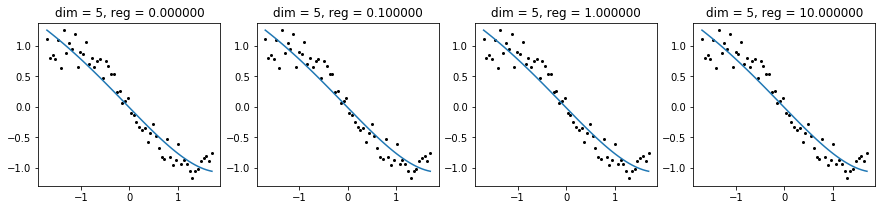





Data with feature dimensions of the order of 10

Ridge Regularization


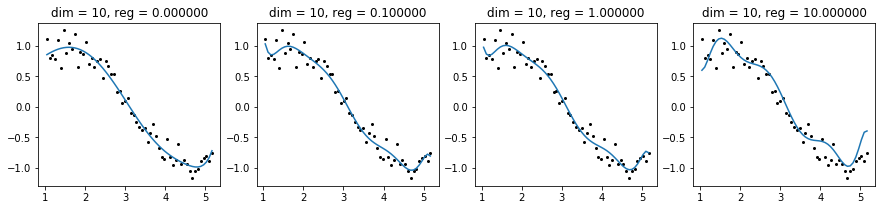


Lasso Regularization


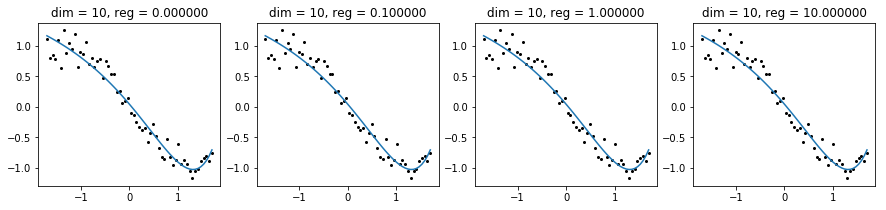





Data with feature dimensions of the order of 15

Ridge Regularization


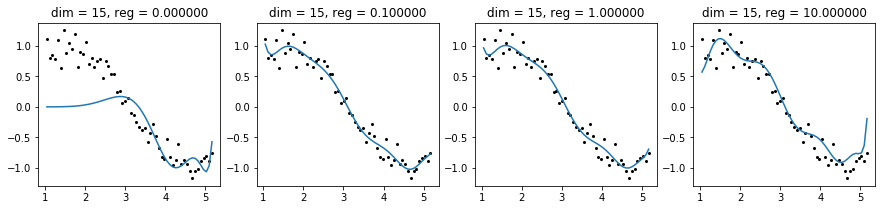


Lasso Regularization


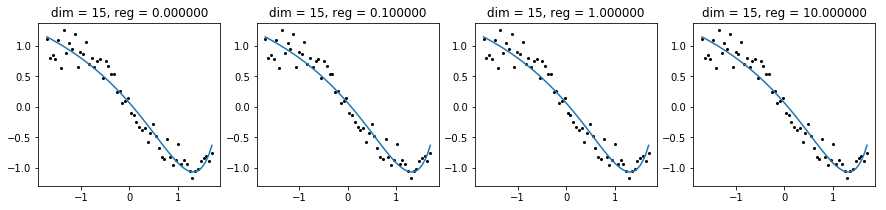

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 3.0) 

D = np.array([5,10,15])
regularization_strengths = np.array([0, 0.1, 1, 10])

for dim in D:
    print ("\n")
    X = np.ones((len(x), dim+1))
    for i in range(1, dim+1):
        X[:,i] = x**i
    
    print ("Data with feature dimensions of the order of %d" % dim)
    ridgeModels = []
    lassoModels = []
    for reg in regularization_strengths:
        ridgeModels.append(estimate_model_ridge(X, y, reg, verbose=False))
        alpha = 0.05
        mu, sd, df = normalize_features(X[:, 1:])
        Xnorm = X
        Xnorm[:,1:] = df
        lassoModels.append(estimate_model_lasso(Xnorm, y, reg, verbose=False))
    print("\nRidge Regularization")
    plot_model_variations(dim, x, y, ridgeModels, regularization_strengths)
    
    print("\nLasso Regularization")
    plot_model_variations(dim, Xnorm[:,1], y, lassoModels, regularization_strengths)
    
    print ("\n")

These figures show the differences of the regularization techniques.

- When the dimensions of data/ features are less, ridge regularization seems to perform really well on data, capturing the variance and making a good fit while lasso regularization suffers due to penalizing the we.
- As the dimensions increase, the lasso regularization sets the weights of many features to nearly zero, thus behaving as auto-selector for significantly contributing features and hence very well takes care of the issue of overfitting.